# Learn Transitions

Example of how to train the EI mismatch network to learn the maze transitions from current and previous state observations

In [1]:
"""
Created by Flavio Martinelli at 9:32 04/06/2020
"""

import os
import sys
import tfmpl

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import tensorflow as tf
import numpy.random as rd
import tensorflow.keras as keras
import matplotlib.pyplot as plt

from tqdm import tqdm
from datetime import datetime

from maze_tf import Maze2D
from neuron_models_old import SnnLoop
from neuron_models import Lif3fLoop
from utils import average_w_matrix
from sklearn.preprocessing import normalize
from plot_utils import raster_plot, v_plot, draw_matrix_tb, annotate_yrange

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

### Define network and simulation parameters

In [2]:
maze_size = (4,4)

theta = 0.3169981156555285
eta1 = 0.0009796194970225012
eta2 = 0.015360662582262801

t_steps = 100
epochs = 1500*5
# epochs = 3000
out_in_ratio = 2**3

seed = 145
tf.random.set_seed(seed)
rd.seed(seed)

### Maze initialization
see [showcase_maze_task.ipynb](showcase_maze_task.ipynb) for more infos

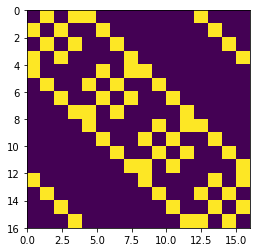

In [3]:
mz = Maze2D(maze_size, walls=False)

# Deactivate reward to prevent random repositioning
mz.reward_pos = None

t_mat = mz.build_transition_matrix()
mz.set_spike_train_params(t_steps, high_freq_p=1.0, low_freq_p=0.0)

f,ax = plt.subplots(1,1, figsize=maze_size)
mz.plot_t_mat(ax)
plt.show()

In [4]:
n_in = mz.tot_room_number
n_err = mz.tot_room_number*out_in_ratio

logbase = "goodlogs/"
# logbase = "logs/"

logdir = logbase + "stochastic_transitions" + f"{n_in}_{n_in}+{n_err}/" + f"seed{seed}/" + datetime.now().strftime("%m%d-%H%M")
writer = tf.summary.create_file_writer(logdir)
logdir

'goodlogs/stochastic_transitions16_16+128/seed145/0605-1246'

### Weight initialization
The weight matrix combines both populations for ease of computation

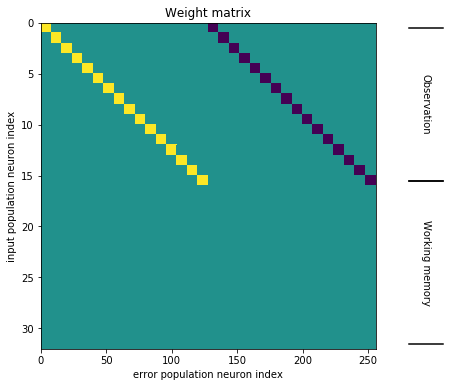

In [5]:
# Initialize network [two input sets of size n_in and two output populations of size n_err]

# Block identity matrix
obs_m1 = (1.0) * np.kron(np.eye(n_in), np.ones([1, out_in_ratio]))  #martin put them to 1 too

# wm_m1 = rd.uniform(1.5, 2., (n_in, n_pop))
wm_m1 = np.zeros((n_in, n_err))

full_w_in = np.block([[obs_m1, -obs_m1], [-wm_m1, wm_m1]])

f,ax = plt.subplots(1,1, figsize=(6,6))
mz.plot_t_mat(ax, full_w_in)
ax.set_title('Weight matrix')
ax.set_xlabel('error population neuron index')
ax.set_ylabel('input population neuron index')
annotate_yrange(0.5,15.5, f'Observation', offset=1.1, width=0.1, ax=ax, text_kwargs={'rotation':-90})
annotate_yrange(15.5,31.5, f'Working memory', offset=1.1, width=0.1, ax=ax, text_kwargs={'rotation':-90})

plt.show()

### Network and input initialization 

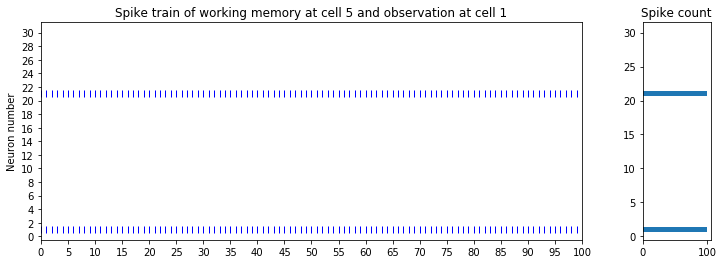

In [6]:
net = Lif3fLoop(n_obs=n_in, n_wm=n_in, n_err1=n_err, n_err2=n_err, w_in=full_w_in, eta1=eta1, eta2=eta2, theta=theta)

# create observation and working memory input spike trains and concatenate them together [1, t_steps, n_in * 2]
spk_wm = tf.squeeze(Maze2D.spk_train_to_tensor(mz.generate_spike_train(mz._state)))

old_pos = mz._state
action = rd.randint(4)
transition = mz._step(action)
new_pos = transition.observation[0]

spk_obs = tf.squeeze(Maze2D.spk_train_to_tensor(mz.generate_spike_train(mz._state)))
inputs = tf.concat([spk_obs, spk_wm], axis=-1)



f, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [8, 1]})

raster_plot(ax, inputs, linewidth = 1, color='b')
ax.set_title(f'Spike train of working memory at cell {old_pos} and observation at cell {mz._state}')
ax.set_ylabel("Neuron number")

spk_count = tf.reduce_sum(inputs, axis=0)
ax2.barh(np.arange(n_in*2), spk_count)
ax2.set_title("Spike count")
# ax2.axes.get_yaxis().set_visible(False)
ax2.set_ylim(ax.get_ylim())
plt.show()

### Simulation

In [7]:
a_trace = []
s_trace = []
f_trace = []
t_mat_trace = [t_mat]

rnn_inner_state = None

last_v = None
last_activity = None


@tf.function
def run_step(inp, v, a):
    return net.run(inp, v, a)

# %load_ext tensorboard
# %tensorboard --logdir logs

In [8]:
for e in tqdm(range(epochs)):
    v, z, activity, surprise = run_step(inputs, last_v, last_activity)

    old_pos = new_pos
    action = rd.randint(4)
    transition = mz._step(action)
    new_pos = transition.observation[0]

    spk_wm = spk_obs  # generate old position spike train again
    spk_obs = Maze2D.spk_train_to_tensor(mz.generate_spike_train(mz._state))
    inputs = tf.concat([tf.squeeze(spk_obs), tf.squeeze(spk_wm)], axis=-1)

    last_v = v[-1]
    last_activity = activity[-1]

    # switch transition matrix
    if e % 1500 == 0 and e != 0:
        t_mat = mz.shuffle()
        t_mat_trace.append(t_mat)

    # Compute metrics
    a_trace.append(activity)
    s_trace.append(surprise)

    learned_t_mat = average_w_matrix(net.w_in*1.0, out_in_ratio)
    learned_t_mat = normalize(learned_t_mat[n_in:, n_in:], norm='l1', axis=0)
    f_trace.append(np.sum((t_mat-learned_t_mat)**2))

    with writer.as_default():
        tf.summary.scalar('frobenius_norm_transition_error', f_trace[-1], step=e)
        tf.summary.scalar('average_surprise', tf.reduce_mean(s_trace[-1]), step=e)
        tf.summary.scalar('average_activity', tf.reduce_mean(a_trace[-1]) / net.A0, step=e)

        if e % 500 == 0:
            tf.summary.image('learnt_transition_matrix', draw_matrix_tb(learned_t_mat), step=e)
            if e % 1500 == 0:
                tf.summary.image('true_transition_matrix', draw_matrix_tb(t_mat), step=e)

  0%|                                                                                         | 0/7500 [00:00<?, ?it/s]

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


100%|██████████████████████████████████████████████████████████████████████████████| 7500/7500 [03:42<00:00, 33.76it/s]


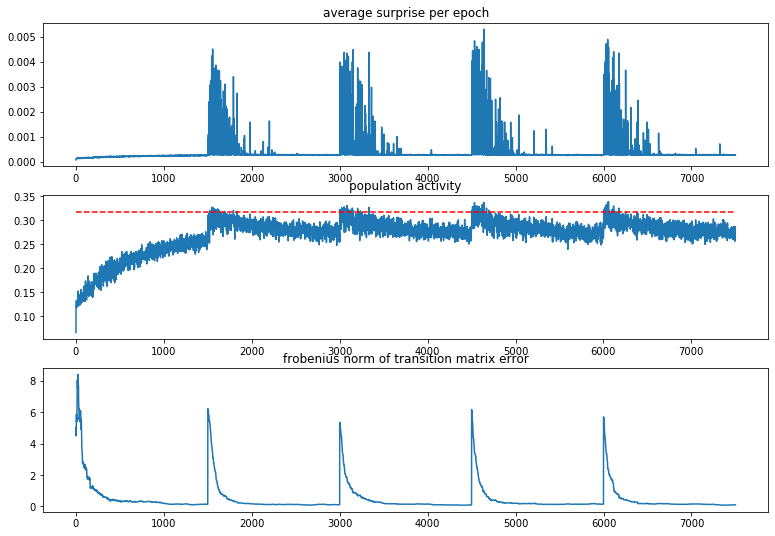

In [9]:
_, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(13,9))
ax1.plot(tf.reduce_mean(s_trace, axis=1))
ax1.set_title('average surprise per epoch')

ax2.plot(np.array(tf.reduce_mean(tf.stack(a_trace), axis=1) / net.A0))
ax2.set_title('population activity')
ax2.hlines(theta, 0, epochs, 'r','--', zorder=3)

ax3.plot(np.array(f_trace))
ax3.set_title('frobenius norm of transition matrix error')
plt.show()


## Simulate step by step and view of error population


In [11]:
act_str = ['right', 'left', 'down', 'up']

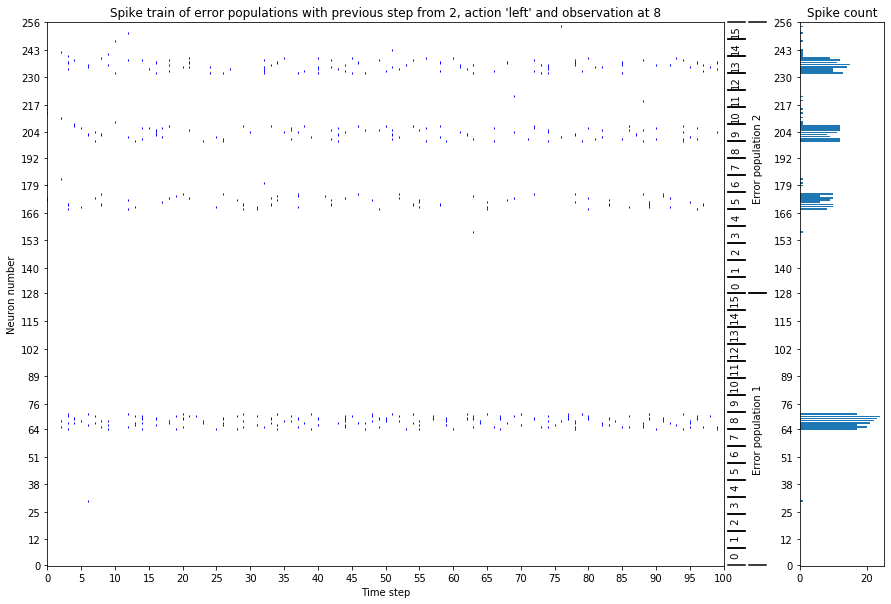

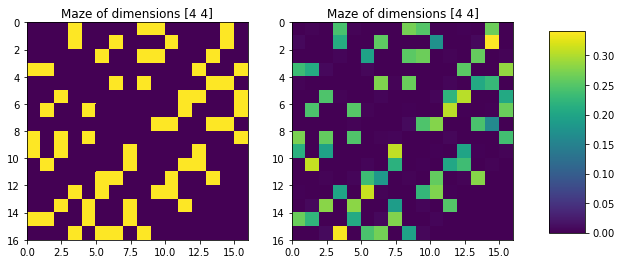

In [25]:
old_pos = mz._state
action = rd.randint(4)
transition = mz._step(action)
new_pos = transition.observation[0]

spk_wm = tf.squeeze(Maze2D.spk_train_to_tensor(mz.generate_spike_train(old_pos)))
spk_obs = Maze2D.spk_train_to_tensor(mz.generate_spike_train(mz._state))
inputs = tf.concat([tf.squeeze(spk_obs), tf.squeeze(spk_wm)], axis=-1)

v, z, activity, surprise = run_step(inputs, last_v, last_activity)

f, (ax, ax2) = plt.subplots(1, 2, figsize=(15, 10), gridspec_kw={'width_ratios': [8, 1]})

raster_plot(ax, z, linewidth = 1, color='b')
ax.set_title(f"Spike train of error populations with previous step from {old_pos}, action '{act_str[action]}' and observation at {new_pos}")
ax.set_ylabel("Neuron number")
ax.set_xlabel("Time step")

spk_count = tf.reduce_sum(z, axis=0)
ax2.barh(np.arange(z.shape[1]), spk_count)
ax2.set_title("Spike count")
# ax2.axes.get_yaxis().set_visible(False)
ax2.set_ylim(ax.get_ylim())

ax2.set_yticks(np.floor(np.linspace(0, z.shape[1], 21)))
ax.set_yticks(np.floor(np.linspace(0, z.shape[1], 21)))

# annotate_yrange(-.5, 15.5, f'Obs', offset=-0.75, width=0.4, ax=ax2, text_kwargs={'rotation':90})

for i in range(mz.tot_room_number):
    annotate_yrange(i*out_in_ratio, (i+1)*out_in_ratio, f' {i}',
                    offset=-0.85, width=0.2, ax=ax2, text_kwargs={'rotation':90})
    annotate_yrange((i+mz.tot_room_number)*out_in_ratio, (i+1+mz.tot_room_number)*out_in_ratio, f'{i}',
                    offset=-0.85, width=0.2, ax=ax2, text_kwargs={'rotation':90})

annotate_yrange(0, mz.tot_room_number*out_in_ratio, f'Error population 1',
                offset=-0.60, width=0.2, ax=ax2, text_kwargs={'rotation':90})
annotate_yrange(mz.tot_room_number*out_in_ratio, 2*mz.tot_room_number*out_in_ratio, f'Error population 2',
                offset=-0.60, width=0.2, ax=ax2, text_kwargs={'rotation':90})

# Plot transitions to help understand the actions

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
pcol = mz.plot_t_mat(ax1, t_mat=t_mat)
ax1.set_title(f"Maze of dimensions {mz.size}")

pcol = mz.plot_t_mat(ax2, t_mat=learned_t_mat[-n_in:, -n_in:])
ax2.set_title(f"Maze of dimensions {mz.size}")
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pcol, cax=cbar_ax)

plt.show()